In [1]:
print("Hello World")

Hello World


In [2]:
import torch

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.device_count()

1

In [5]:
torch.cuda.get_device_name()

'NVIDIA L40S'

In [6]:
!git clone https://github.com/Laoode/Fingerprint_Recognition.git

Cloning into 'Fingerprint_Recognition'...



In [7]:
!pip install -r requirements.txt

In [8]:
import os

# Cek folder kerja saat ini
current_directory = os.getcwd()
print("Current directory:", current_directory)

# Cek isi folder kerja
print("Files and directories in current directory:")
print(os.listdir(current_directory))

Current directory: /jupyter-lab-notebook-dir
Files and directories in current directory:
['notebook.ipynb', 'Fingerprint_Recognition', 'requirements.txt']


In [9]:
!pip install gdown

In [12]:
!gdown 'https://drive.google.com/uc?id=1wuf73k3yExMPDR62P9XqrJx1cOmfZaIf'

Downloading...
From (original): https://drive.google.com/uc?id=1wuf73k3yExMPDR62P9XqrJx1cOmfZaIf
From (redirected): https://drive.google.com/uc?id=1wuf73k3yExMPDR62P9XqrJx1cOmfZaIf&confirm=t&uuid=ad20e29d-9e96-4838-9243-fbf4e0e3bae0
To: /jupyter-lab-notebook-dir/Data.zip
100%|████████████████████████████████████████| 236M/236M [00:07<00:00, 33.6MB/s]


In [13]:
import zipfile
import os

# Nama file ZIP yang ingin diekstrak
zip_file = 'Data.zip'

# Tentukan direktori untuk ekstraksi (opsional)
extract_dir = 'Data-set'  # Ganti dengan nama folder yang diinginkan

# Buat direktori ekstraksi jika belum ada
os.makedirs(extract_dir, exist_ok=True)

# Ekstrak file ZIP
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f'File telah diekstrak ke: {extract_dir}')


File telah diekstrak ke: Data-set


In [24]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib.patches import Circle,Ellipse
from matplotlib.patches import Rectangle
import os
from PIL import Image
from skimage.transform import resize

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline

2024-10-13 23:30:04.289047: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 23:30:04.304838: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-13 23:30:04.304864: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-13 23:30:04.315703: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-13 23:30:05.077308: W tensorflow/compiler/tf

In [26]:
from pathlib import Path

In [27]:
#  All dataset path
dataset_path = list(Path('Data-set').rglob('*.tif'))

In [28]:
print(len(dataset_path))

2688


In [29]:
images = []
def read_images(dataset_path):
    for i in range(len(dataset_path)):
        img = Image.open(dataset_path[i])
        img = img.resize((224, 224))
        img = np.array(img) 
        images.append(img)
    return images

In [30]:
images = read_images(dataset_path)

In [31]:
images_arr = np.asarray(images)
images_arr = images_arr.astype('float32')

In [32]:
images_arr.shape

(2688, 224, 224)

## Data Exploration

In [33]:
# Shapes of training set
print("Dataset (images) shape: {shape}".format(shape=images_arr.shape))

Dataset (images) shape: (2688, 224, 224)


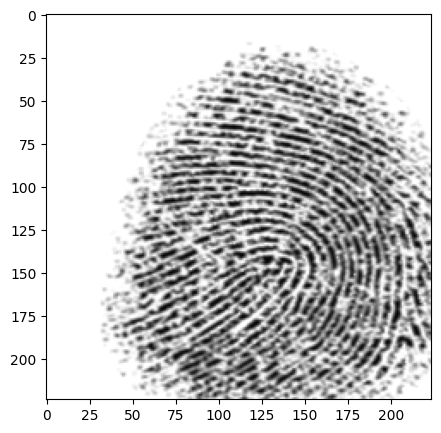

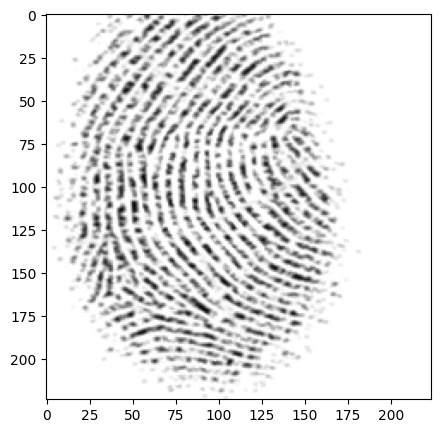

In [34]:
#plt.figure(figsize=[5,5])

# Display the first image in training data
for i in range(2):
    plt.figure(figsize=[5, 5])
    curr_img = np.reshape(images_arr[i], (224,224))
    plt.imshow(curr_img, cmap='gray')
    plt.show()

## Data Preprocessing

In [35]:
images_arr = images_arr.reshape(-1, 224,224, 1)

In [36]:
images_arr.shape

(2688, 224, 224, 1)

In [37]:
images_arr.dtype

dtype('float32')

In [38]:
np.max(images_arr)

255.0

In [39]:
images_arr = images_arr / np.max(images_arr)

In [40]:
np.max(images_arr), np.min(images_arr)

(1.0, 0.0)

In [41]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(images_arr,
                                                             images_arr,
                                                             test_size=0.2,
                                                             random_state=13)

## Network: The Convolutional Autoencoder

In [8]:
batch_size = 128
epochs = 200
inChannel = 1
x, y = 224, 224
input_img = Input(shape = (x, y, inChannel))

In [9]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [57]:
autoencoder_model = Model(input_img, autoencoder(input_img))
autoencoder_model.compile(loss='mean_squared_error', optimizer = RMSprop())

In [58]:
autoencoder_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 224, 224, 1)    │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,625 (1.20 MB)

 Trainable params: 314,625 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Memuat bobot sebelumnya jika ada
autoencoder_model.load_weights('autoencoder.weights.h5')

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Train the Model

In [60]:
autoencoder_train = autoencoder_model.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - loss: 0.0080 - val_loss: 0.0070
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0069 - val_loss: 0.0062
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0065 - val_loss: 0.0063
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0068 - val_loss: 0.0062
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0065 - val_loss: 0.0068
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0068 - val_loss: 0.0064
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0063 - val_loss: 0.0062
Epoch 8/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0065 - val_loss: 0.0062
Epoch 9/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0067 - val_loss: 0.0070
Epoch 10/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 11/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 12/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2

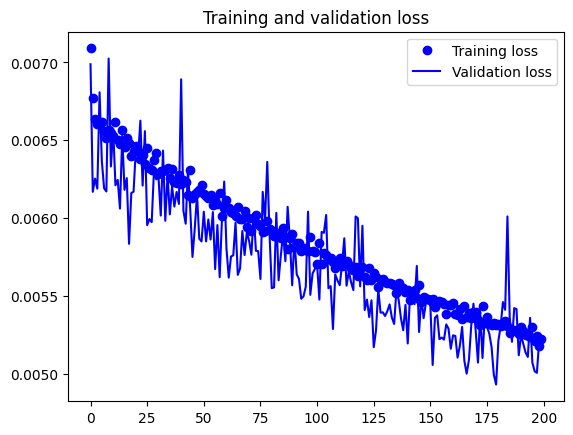

In [61]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [65]:
autoencoder_model.save_weights('autoencoder-2.weights.h5')

In [62]:
# Menghitung loss pada data validasi
loss = autoencoder_model.evaluate(valid_X, valid_ground)  # Ini akan mengembalikan loss

# Jika model di compile dengan loss='mean_squared_error', nilai ini adalah metrik yang kamu cari.
print(f'Validation Loss: {loss:.4f}')

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0055
Validation Loss: 0.0052


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


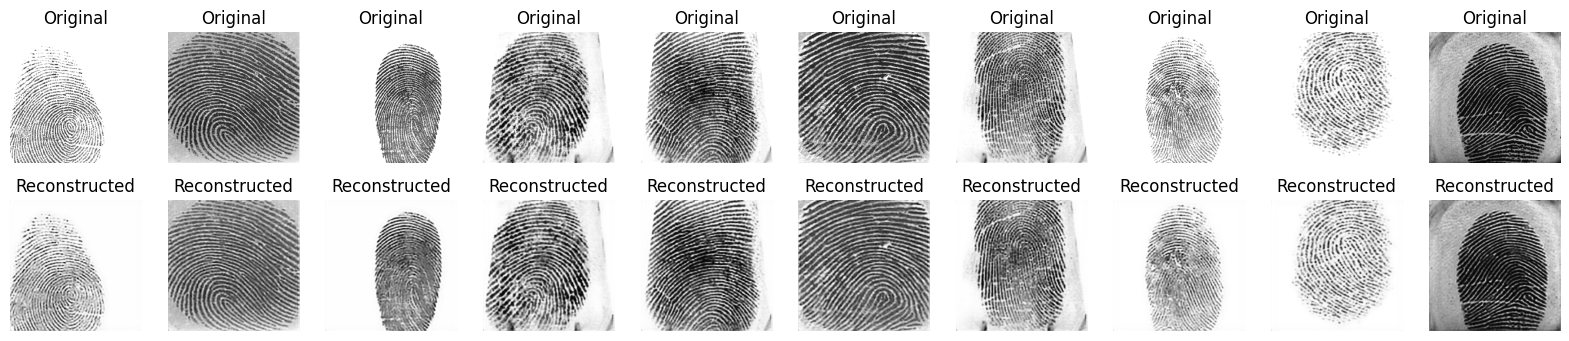

In [66]:
decoded_imgs = autoencoder_model.predict(valid_X)  # Menggunakan validasi untuk prediksi
n = 10  # jumlah gambar yang ingin ditampilkan
plt.figure(figsize=(20, 4))
for i in range(n):
    # Gambar asli
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(valid_X[i].reshape(224, 224), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Gambar rekonstruksi
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(224, 224), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

From the above figures, you can observe that your model did a fantastic job of reconstructing the test images that you predicted using the model. At least visually, the test and the reconstructed images look almost exactly similar.

## Predicting on Two Different Sensor Data using the Trained Model

First I will use another data sets, which means is not there is my train, validate data before.
<br>
I will be testing my model on two different types of sensors.
- Hisign
- digital camera

In [6]:
from tensorflow.keras.models import load_model

In [67]:
!gdown 'https://drive.google.com/uc?id=1LruYrACXELcGvPckNEhguzz8Z7yTZ2zd'

Downloading...
From: https://drive.google.com/uc?id=1LruYrACXELcGvPckNEhguzz8Z7yTZ2zd
To: /jupyter-lab-notebook-dir/fingerprint_bitmaps.zip
100%|███████████████████████████████████████| 8.94M/8.94M [00:00<00:00, 116MB/s]


In [5]:
# Nama file ZIP yang ingin diekstrak
zip_file = 'fingerprint_bitmaps.zip'

# Tentukan direktori untuk ekstraksi (opsional)
extract_dir = 'New-Data-set'  # Ganti dengan nama folder yang diinginkan

# Buat direktori ekstraksi jika belum ada
os.makedirs(extract_dir, exist_ok=True)

# Ekstrak file ZIP
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f'File telah diekstrak ke: {extract_dir}')

File telah diekstrak ke: New-Data-set


In [10]:
# Buat model
autoencoder_model = Model(input_img, autoencoder(input_img))

In [11]:
# Muat bobot
autoencoder_model.load_weights('autoencoder-2.weights.h5')

In [12]:
# Define the path to your new dataset
new_dataset_path = 'New-Data-set/'  # Update this path
new_images = []

In [13]:
# Load and preprocess the images
for filename in os.listdir(new_dataset_path):
    if filename.endswith('.bmp'):  # Ensure you're only processing BMP files
        img_path = os.path.join(new_dataset_path, filename)
        img = Image.open(img_path)
        img = img.resize((224, 224))  # Resize to match the input size of the model
        img = img.convert('L')  # Convert to grayscale if needed
        img_array = np.array(img).astype(np.float32) / 255.0  # Normalize the pixel values
        new_images.append(img_array)

In [14]:
# Convert to numpy array
new_images_arr = np.array(new_images).reshape(-1, 224, 224, 1)  # Reshape for model input

# Use the trained model to predict
predicted_images = autoencoder_model.predict(new_images_arr)


6/6 ━━━━━━━━━━━━━━━━━━━━ 49s 8s/step


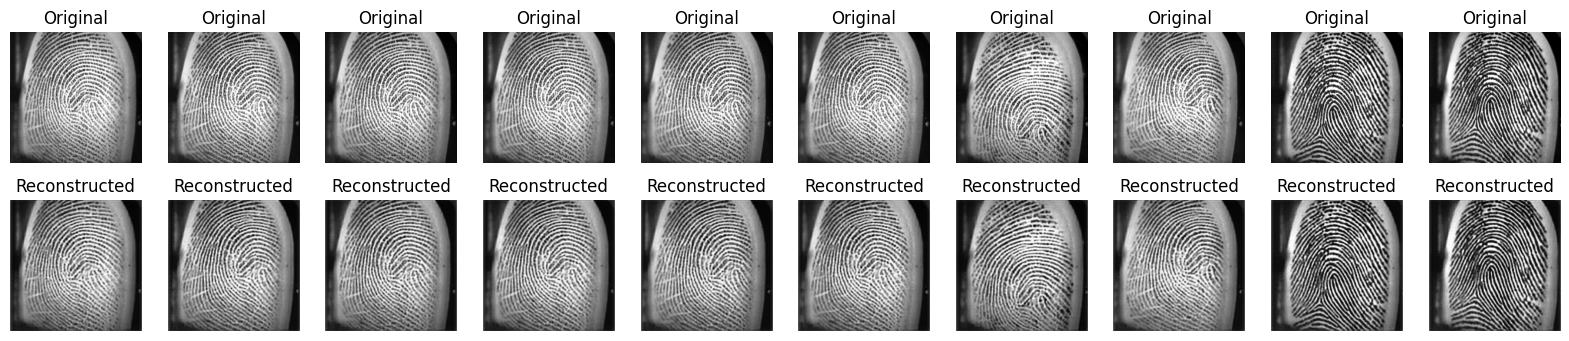

In [17]:
import random

# Sample a random subset of indices
sample_indices = random.sample(range(len(new_images_arr)), 10)

plt.figure(figsize=(20, 4))
for i, index in enumerate(sample_indices):
    # Original Image
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(new_images_arr[i].reshape(224, 224), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed Image
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(predicted_images[i].reshape(224, 224), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

## Gradient-weighted Class Activation Mapping (Grad-CAM)

In [18]:
def generate_gradcam(model, img_array, layer_name, class_index):
    # Create a model that will return the outputs of the last convolutional layer
    grad_model = tf.keras.models.Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])
    
    # Use tf.GradientTape for gradient calculation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(tf.expand_dims(img_array, axis=0))
        loss = predictions[0][class_index]  # Change to the appropriate class index

    # Get the gradients of the loss with respect to the convolutional output
    grads = tape.gradient(loss, conv_outputs)

    # Pool the gradients across the channels
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # Multiply each channel in the feature map by the "pooled" gradients
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]

    # Apply ReLU to the heatmap
    heatmap = tf.maximum(heatmap, 0)

    # Normalize the heatmap
    heatmap /= tf.reduce_max(heatmap)

    return heatmap.numpy()


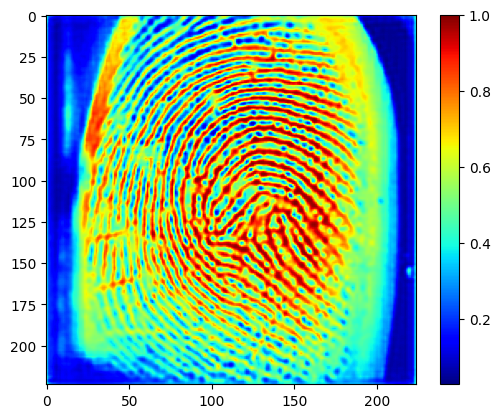

In [21]:
layer_name = 'conv2d_5'  # Specify the convolutional layer name
class_index = 0  # Placeholder value since autoencoders don't have classes

heatmap = generate_gradcam(autoencoder_model, new_images_arr[0], layer_name, class_index)

# Display the heatmap
plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.show()


<i>The red color indicates areas with high activation, while the blue color indicates areas with low activation. This indicates the parts of the image that contribute most to the model's decision to classify the fingerprint.</i>

## Fingerprint Matching

In [22]:
# Simpan model beserta arsitektur dan bobot
autoencoder_model.save('autoencoder_complete_model.h5')

In [23]:
# Memuat model lengkap dari file .h5
loaded_model = load_model('autoencoder_complete_model.h5')

In [27]:
# Fungsi untuk memuat dan memproses gambar sidik jari
def load_and_process_image(image_path, img_shape):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Membaca gambar dalam grayscale
    img = cv2.resize(img, (img_shape[1], img_shape[0]))  # Mengubah ukuran gambar
    img = img.reshape((1, img.shape[0], img.shape[1], 1))  # Menambahkan dimensi batch
    img = img / 255.0  # Normalisasi pixel
    return img

In [28]:
# Fungsi untuk mencocokkan sidik jari dengan menghitung perbedaan antara rekonstruksi
def match_fingerprints(loaded_model, img_path_evidence, img_path_suspect, img_shape):
    # Memproses gambar sidik jari barang bukti
    img_evidence = load_and_process_image(img_path_evidence, img_shape)
    
    # Memproses gambar sidik jari terduga
    img_suspect = load_and_process_image(img_path_suspect, img_shape)
    
    # Merekonstruksi gambar barang bukti dan terduga menggunakan autoencoder
    reconstructed_evidence = loaded_model.predict(img_evidence)
    reconstructed_suspect = loaded_model.predict(img_suspect)

    # Menghitung error rekonstruksi menggunakan perbedaan L2 atau SSIM
    error_evidence = np.mean(np.square(img_evidence - reconstructed_evidence))
    error_suspect = np.mean(np.square(img_suspect - reconstructed_suspect))

    # Menampilkan hasil perbandingan rekonstruksi
    print(f"Hasil Perbandingan Rekonstruksi:")
    print(f"Error Rekonstruksi Barang Bukti: {error_evidence:.4f}")
    print(f"Error Rekonstruksi Terduga: {error_suspect:.4f}")

    # Menampilkan gambar asli dan rekonstruksi
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    
    axs[0, 0].imshow(img_evidence.reshape(img_shape), cmap='gray')
    axs[0, 0].set_title("Sidik Jari Barang Bukti (Asli)")
    axs[0, 0].axis('off')

    axs[0, 1].imshow(reconstructed_evidence.reshape(img_shape), cmap='gray')
    axs[0, 1].set_title("Sidik Jari Barang Bukti (Rekonstruksi)")
    axs[0, 1].axis('off')

    axs[1, 0].imshow(img_suspect.reshape(img_shape), cmap='gray')
    axs[1, 0].set_title("Sidik Jari Terduga (Asli)")
    axs[1, 0].axis('off')

    axs[1, 1].imshow(reconstructed_suspect.reshape(img_shape), cmap='gray')
    axs[1, 1].set_title("Sidik Jari Terduga (Rekonstruksi)")
    axs[1, 1].axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step
Hasil Perbandingan Rekonstruksi:
Error Rekonstruksi Barang Bukti: 0.0116
Error Rekonstruksi Terduga: 0.0121


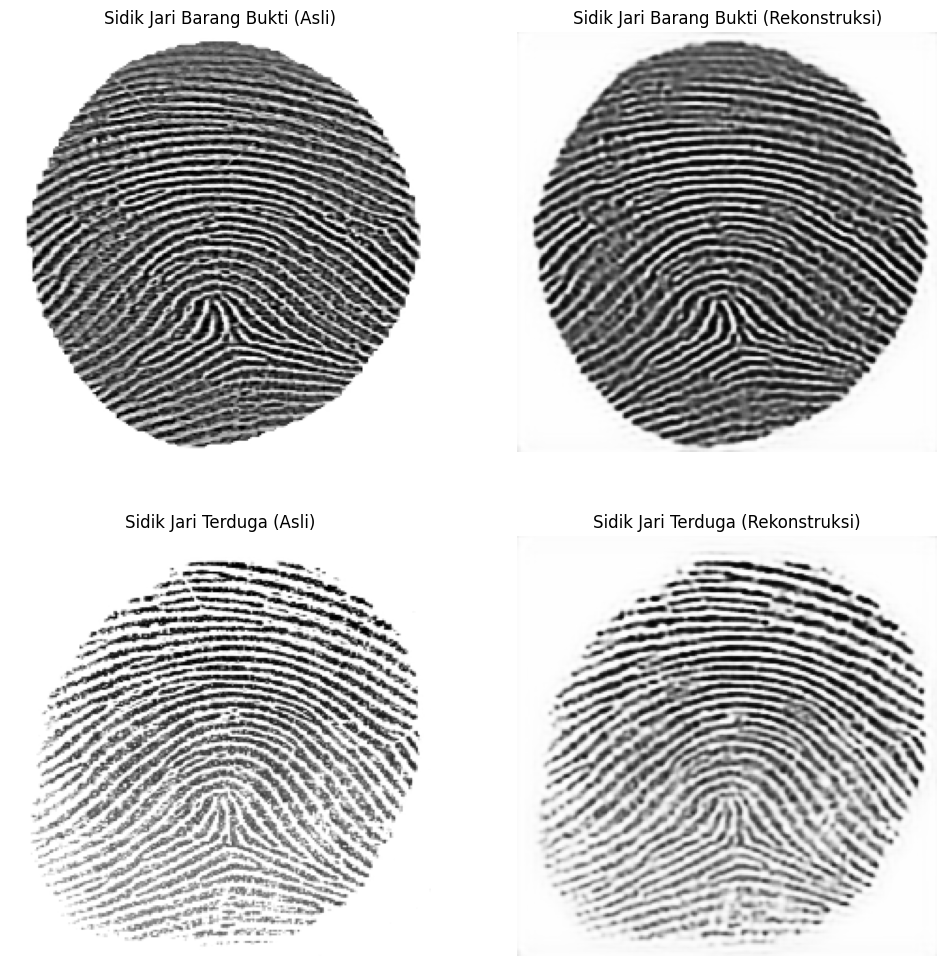

In [30]:
# Parameter model
img_shape = (224, 224)  # Ubah sesuai dengan ukuran input model Anda
# Input gambar sidik jari barang bukti dan terduga
img_path_evidence = "Bukti/MSI-1.png"
img_path_suspect = "Terduga/TIR-1.png"

# Mencocokkan sidik jari
match_fingerprints(loaded_model, img_path_evidence, img_path_suspect, img_shape)